# This Notebook will include graphical analysis of Amazon review data

Source:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects.

Jianmo Ni, Jiacheng Li, Julian McAuley.

Empirical Methods in Natural Language Processing (EMNLP), 2019.

https://nijianmo.github.io/amazon/index.html

http://deepyeti.ucsd.edu/jianmo/amazon/index.html

------------------------------

Sentiment analysis code shall be later on transfered to .py files for easy execution

---------------

In [81]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import math
from scipy.spatial import distance
from sklearn.metrics import accuracy_score

# custom files
from word_vectorization import create_tf_vector_all_reviews, create_idf_dictionary, create_word_vector_dict

In [2]:
# read data
path = "./data/AMAZON_FASHION_5.json"

data = pd.read_json(path, lines = True)

In [3]:
# get first look
print(f"Data has {len(data)} datapoints.")
print(f"Data has {len(data.columns)} Columns.")

print("Columns:")
print(list(data.columns))

Data has 3176 datapoints.
Data has 12 Columns.
Columns:
['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote', 'image']


In [4]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
1,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Black (3746...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
2,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
3,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue (37867...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
4,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Pink'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN


In [5]:
# drop unnedded columns
columns_keep = ["overall", "reviewText", "summary"]
drop_columns = [i for i in list(data.columns) if i not in columns_keep]

data.drop(drop_columns, axis=1, inplace=True)

# drop nan
print(len(data))
data = data.dropna()
print(len(data))

3176
3160


Most saved rating is 5 with 2142 datapoints.
Least saved rating is 2 with 93 datapoints.


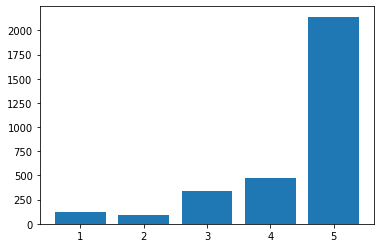

In [6]:
# how many datapoints per rating
rating_count = {}
all_ratings = sorted(data["overall"].unique())


for rating in all_ratings:
    
    rating_count[rating] = len(data[data["overall"] == rating])

# data information
most_rated = max(rating_count, key = rating_count.get)
least_rated = min(rating_count, key = rating_count.get)
print(f"Most saved rating is {most_rated} with {rating_count[most_rated]} datapoints.")
print(f"Least saved rating is {least_rated} with {rating_count[least_rated]} datapoints.")

# show graph
plt.bar(list(rating_count.keys()), list(rating_count.values()))
plt.show()

-----------

# provisionally Conclusion

Sample Data is highly imbalanced.

For now there should be used a sub_dataset with evenly distributed data.

This effect should be considered when using whole dataset

------------

In [7]:
# create balanced dataset by min count class (function from: https://stackoverflow.com/questions/45839316/pandas-balancing-data)
data_balanced = data[data["overall"] == least_rated]
remain_ratings = [i for i in all_ratings if i != least_rated]


for remain_rating in remain_ratings:
    
    # append data
    data_balanced = data_balanced.append(data[data["overall"] == remain_rating][:rating_count[least_rated]])

# reset index
data_balanced = data_balanced.reset_index(drop = True)

In [8]:
# methods defined in word_vectorization.py

# create review_dict
review_dict = create_tf_vector_all_reviews(data_balanced)

# create idf dict
idf_dict = create_idf_dictionary(review_dict)

# create word_vec_dict
word_vec_dict = create_word_vector_dict(review_dict, idf_dict)

# include word_vec_dict in dataframe
data_balanced["word_vectors"] = word_vec_dict.values()

In [9]:
# get a look at the data
data_balanced.head()

,overall,reviewText,summary,word_vectors
0,2,Relieved my Plantar Fascitis for 3 Days. Then ...,These were recommended by my Podiatrist,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,This is my 6th pair and they are the best thin...,Not the same as all my other pairs.,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,Relieved my Plantar Fascitis for 3 Days. Then ...,These were recommended by my Podiatrist,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2,This is my 6th pair and they are the best thin...,Not the same as all my other pairs.,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2,Nice pants but too small for a medium. Return it.,Returned also,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
# create test and training dataset
test_size = 0.2
train_data, test_data = train_test_split(data_balanced,
                                         test_size = test_size,
                                         shuffle=True,
                                         stratify = data_balanced["overall"]
                                        )

train_data = train_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

-------

# Now start Sentiment analysis

-------

In [11]:
# now implement naive bayes

In [42]:
train_data.head(10)

,overall,reviewText,summary,word_vectors
0,2,I'm not sure I was shipped the correct style. ...,Huh,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,4,"For the price I spent on the pair of shoes, I'...",Pretty comfortable pair of running shoes,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,I bought these for gym training - weight class...,"Zumba) - and really wanted to like them, since...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,After using this shoes seven times for regular...,Poor Quality. Don't buy.,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,Havaiana's are THE BEST!!!,Five Stars,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,1,After using this shoes seven times for regular...,Poor Quality. Don't buy.,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,1,After less than a week the sole ripped off on ...,Poor quality for Nike,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,5,Pinnacle seems to have more cushioning so my h...,Personal favorite,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,4,Excellent value,excellent value and quality,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,1,They looked very cheap,Returned...looked cheap,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [67]:
# Implement K nearest Neigbours
def knn(train_data, data_point, n):
    
    vectors = train_data["word_vectors"].to_list()
    
    distances = {}
    count = 0
    
    for vector in vectors:
        
        distances[count] = distance.euclidean(data_point, np.asarray(vector))
        count += 1
    
    # sort dictionary
    distances = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1])}
    
    classes_indexes = list(distances.keys())[:n]
    classes = {}
    
    for i in classes_indexes:
        
        if train_data.iloc[i]["overall"] in list(classes.keys()):
            
            classes[train_data.iloc[i]["overall"]] += 1
        
        else:
            
            classes[train_data.iloc[i]["overall"]] = 1
    
    max_class = max(classes, key = classes.get)
    
    return max_class

In [79]:
test_vectors = test_data["word_vectors"].to_list()
test_classes = test_data["overall"].to_list()

In [95]:
def test(n_test):

    pred_class = []
    for t_vector in test_vectors:

        pred_class.append(knn(train_data, np.asarray(t_vector), n_test))

    accuracy = accuracy_score(test_classes, pred_class)
    #print(f"accuracy is: {accuracy}")
    return accuracy

In [97]:
evalualtion_dict = {}

for n_test in range(1, 30):
    
    evalualtion_dict[n_test] = test(n_test)

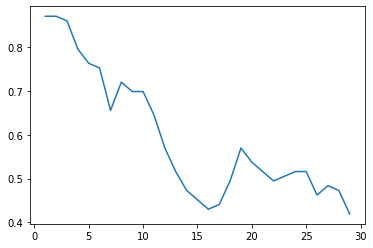

In [98]:
# visualize
plt.plot(list(evalualtion_dict.keys()), list(evalualtion_dict.values()))
plt.show()

----------

Task: knn in own python file, rewrite to be completly independent of other libs

-------------

In [39]:
test = vectors[1]
train = vectors[0]

In [75]:
data_point = np.asarray(test_data.loc[0]["word_vectors"])

In [76]:
print(knn(train_data, data_point, 10))

2


In [70]:
test_data.head(10)

,overall,reviewText,summary,word_vectors
0,3,Nice,Three Stars,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,3,They're ugly: the toe is rounded and the mater...,the Nike Womens Flex Trainer 6 is way better l...,"(0.0, 0.0, 0.30975149678639335, 0.0, 0.0, 0.0,..."
2,1,Ordered 9(m) received 9 Wide for the second ti...,One Star,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,I've not even had them a month and the bottom ...,Falling apart already!!,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,3,"I bought a pair of these in my size, but they ...",Get a half-size or more larger than usual.,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,4,Very good overall.\nNow Ive been a huge Sketch...,Good shoes,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,1,Waaaay too BIG,One Star,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,5,Great shoes. Fit perfectly. Comfortable right ...,Great shoes. Fit perfectly,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,2,I returned these as they were not true to size...,Not true to size,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,3,No arch support but l love the colors!,Three Stars,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
